In [1]:
import class_function as cf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('../Data/result_5_merged.csv')
X = data.drop(columns=['TARGET'])
Y = data.TARGET

X.dtypes.value_counts()

float64    37
int64      13
dtype: int64

In [5]:
dummpy_data = pd.DataFrame() 
for col in X.columns: 
    if X[col].ftype == 'int64:dense' and len(X[col].unique()) > 2: 
        dummpy = pd.get_dummies(X[col]) 
        col_name = [col+'_'+str(i) for i in dummpy.columns] 
        dummpy.columns = col_name 
        for col_ in dummpy.columns: 
            dummpy_data[col_] = dummpy[col_]

    else:
        dummpy_data[col] = X[col]
        
        
dummpy_data.shape

(307511, 149)

In [6]:
X = dummpy_data

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [8]:
class Multi_XGB(object):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        pass
    
    def train(self, x_train, y_train):
        data = pd.concat([x_train, y_train], axis=1)
        group_result = data.groupby(y_train.name)
        data_0 = group_result.get_group(0)
        data_1 = group_result.get_group(1)
        #0比1多
        im_dergee = int(data_0.shape[0]/data_1.shape[0])
        self.im_dergee = im_dergee
        data_list = []
        maj_number = data_0.shape[0]
        balanced_number = data_1.shape[0]
        for i in range(im_dergee):
            if i < im_dergee - 1:
                data_list.append(data_0.iloc[i*balanced_number:(i+1)*balanced_number, :])
            else:
                data_list.append(data_0.iloc[i*balanced_number:, :])
        
        #print(data_list[0])
                
        xgb_cla_list = []
        for i in range(im_dergee):
            x_y = pd.concat([data_list[i], data_1], axis=0)
            #print(x_y)
            x_train_ = x_y.iloc[:, :x_y.shape[1]-1]
            y_train_ = x_y.iloc[:, x_y.shape[1]-1]
            #print(y_train_)
            xgb_cla_list.append(xgb.XGBClassifier(**self.kwargs))
            xgb_cla_list[i].fit(x_train_, y_train_)
            print('*' * 40)
            print(xgb_cla_list[i].classes_)
        
        self.xgb_cla_list = xgb_cla_list
        
    def predict(self, x_test, threshold):
        xgb_cla_list = self.xgb_cla_list
        predict_proba_list = []
        for i in range(self.im_dergee):
            predict_proba = xgb_cla_list[i].predict_proba(x_test)
            predict_proba_1 = []
            for j in range(len(predict_proba)):
                predict_proba_1.append(predict_proba[j][1])
                
            predict_proba_list.append(predict_proba_1)
            
        predict_proba = []
        result = []
        for i in range(len(predict_proba_list[0])):
            tmp = 0
            for j in range(len(predict_proba_list)):
                tmp += predict_proba_list[j][i]
            
            proba = tmp / self.im_dergee
            predict_proba.append(proba)
            if proba > threshold:
                result.append(1)
            else:
                result.append(0)
        
        self.predict_proba = predict_proba
        self.result = result
        

In [ ]:
multi_xgb = Multi_XGB(max_depth=10, n_estimators=500, random_state=0)
multi_xgb.train(x_train, y_train)

****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]


In [10]:
multi_xgb.predict(x_test, 0.6)
multi_xgb.result[:5]

[1, 0, 1, 0, 1]

In [11]:
multi_xgb.predict_proba

[0.9205278158187866,
 0.14042221653190526,
 0.638786413452842,
 0.3329123719172044,
 0.8571025945923545,
 0.7379358356649225,
 0.109284389086745,
 0.5418803881515156,
 0.0401083580641584,
 0.3878729892047969,
 0.24036777290430936,
 0.7488491616465829,
 0.2638355954126878,
 0.14050579138777472,
 0.49151918292045593,
 0.29676876826719806,
 0.12893988090482625,
 0.20569008114663037,
 0.17458990622650494,
 0.05773635458370501,
 0.1414475559510968,
 0.5008148144591938,
 0.11630276455120607,
 0.47158278931270947,
 0.3843377659266645,
 0.2221904918551445,
 0.36980979957363824,
 0.3247695822607387,
 0.15346978909590028,
 0.115782673724673,
 0.08426291326230223,
 0.4887560985305093,
 0.8855931921438738,
 0.852005969394337,
 0.48852400346235797,
 0.4782902788032185,
 0.023225642719560048,
 0.22427364100109448,
 0.7184256477789446,
 0.689579963684082,
 0.03352239363911477,
 0.5384646816687151,
 0.6679895655675367,
 0.1498208963735537,
 0.4971148263324391,
 0.49782087857073004,
 0.493860353123058,

In [12]:
fbc = cf.For_binary_classifier(multi_xgb.result, y_test)

                    Real +          Real -     
   Predict +         2903            12137     
   Predict -         1952            44511     

准确率： 0.770921743654781
召回率： 0.5979402677651905
精准率： 0.1930186170212766

漏警率： 0.4020597322348095
虚警率： 0.8069813829787233
F1: 0.29183211862276953
fpr: 0.2142529303770654


In [13]:
threshold_list = np.arange(0, 1, 0.01)
accuracy_list = []
recall_list = []
precision_list = []
MissingAlarm_list = []
FalseAlarm_list = []
F1_list = []
fpr_list = []

y_proba = multi_xgb.predict_proba
for threshold in threshold_list:
    #y_predicted = multi_xgb.predict(x_test, threshold)
    y_predicted = []
    
    for proba in y_proba:
        if proba > threshold:
            y_predicted.append(1)
        else:
            y_predicted.append(0)
            
    fbc = cf.For_binary_classifier(y_predicted, y_test)
    accuracy_list.append(fbc.accuracy)
    recall_list.append(fbc.recall)
    precision_list.append(fbc.precision)
    MissingAlarm_list.append(fbc.MissingAlarm)
    FalseAlarm_list.append(fbc.FalseAlarm)
    F1_list.append(fbc.F1)
    fpr_list.append(fbc.fpr)
    print('*' * 40)
    

                    Real +          Real -     
   Predict +         4855            56648     
   Predict -           0               0       

准确率： 0.0789392387363218
召回率： 1.0
精准率： 0.0789392387363218

漏警率： 0.0
虚警率： 0.9210607612636782
F1: 0.1463274963079056
fpr: 1.0
****************************************
                    Real +          Real -     
   Predict +         4854            56435     
   Predict -           1              213      

准确率： 0.08238622506219209
召回率： 0.9997940267765191
精准率： 0.07919855112662957

漏警率： 0.0002059732234809264
虚警率： 0.9208014488733705
F1: 0.14677068214804065
fpr: 0.9962399378618839
****************************************
                    Real +          Real -     
   Predict +         4850            55784     
   Predict -           5              864      

准确率： 0.09290603710388111
召回率： 0.9989701338825953
精准率： 0.07998812547415642

漏警率： 0.001029866117404743
虚警率： 0.9200118745258435
F1: 0.14811647757638685
fpr: 0.9847479169608813
*************

                    Real +          Real -     
   Predict +         4366            33728     
   Predict -          489            22920     

准确率： 0.443653155130644
召回率： 0.8992790937178167
精准率： 0.11461122486480811

漏警率： 0.10072090628218333
虚警率： 0.8853887751351919
F1: 0.20331090362988663
fpr: 0.5953961304900438
****************************************
                    Real +          Real -     
   Predict +         4327            32895     
   Predict -          528            23753     

准确率： 0.45656309448319593
召回率： 0.8912461380020598
精准率： 0.116248455214658

漏警率： 0.10875386199794024
虚警率： 0.883751544785342
F1: 0.20567055636095727
fpr: 0.580691286541449
****************************************
                    Real +          Real -     
   Predict +         4293            32142     
   Predict -          562            24506     

准确率： 0.4682535811261239
召回率： 0.8842430484037075
精准率： 0.11782626595306711

漏警率： 0.11575695159629251
虚警率： 0.8821737340469329
F1: 0.2079438120610317

                    Real +          Real -     
   Predict +         3477            18028     
   Predict -         1378            38620     

准确率： 0.684470676227176
召回率： 0.7161688980432543
精准率： 0.16168332945826552

漏警率： 0.28383110195674566
虚警率： 0.8383166705417344
F1: 0.2638088012139605
fpr: 0.3182460104505013
****************************************
                    Real +          Real -     
   Predict +         3432            17525     
   Predict -         1423            39123     

准确率： 0.6919174674406127
召回率： 0.7069001029866118
精准率： 0.1637638975044138

漏警率： 0.29309989701338823
虚警率： 0.8362361024955862
F1: 0.26592282659228267
fpr: 0.30936661488490325
****************************************
                    Real +          Real -     
   Predict +         3391            16984     
   Predict -         1464            39664     

准确率： 0.7000471521714388
召回率： 0.6984552008238929
精准率： 0.16642944785276073

漏警率： 0.3015447991761071
虚警率： 0.8335705521472393
F1: 0.268806975822433

                    Real +          Real -     
   Predict +         2157            7103      
   Predict -         2698            49545     

准确率： 0.8406419199063461
召回率： 0.4442842430484037
精准率： 0.23293736501079915

漏警率： 0.5557157569515963
虚警率： 0.7670626349892009
F1: 0.3056323060573857
fpr: 0.12538836322553312
****************************************
                    Real +          Real -     
   Predict +         2106            6730      
   Predict -         2749            49918     

准确率： 0.8458774368729981
召回率： 0.4337796086508754
精准率： 0.2383431416930738

漏警率： 0.5662203913491246
虚警率： 0.7616568583069262
F1: 0.3076473595792857
fpr: 0.118803841265358
****************************************
                    Real +          Real -     
   Predict +         2036            6326      
   Predict -         2819            50322     

准确率： 0.8513080662731899
召回率： 0.41936148300720905
精准率： 0.2434824204735709

漏警率： 0.580638516992791
虚警率： 0.7565175795264291
F1: 0.3080880683967618
fp

                    Real +          Real -     
   Predict +          242             300      
   Predict -         4613            56348     

准确率： 0.9201177178349024
召回率： 0.04984552008238929
精准率： 0.44649446494464945

漏警率： 0.9501544799176107
虚警率： 0.5535055350553506
F1: 0.08967945154715581
fpr: 0.005295862166360683
****************************************
                    Real +          Real -     
   Predict +          150             185      
   Predict -         4705            56463     

准确率： 0.9204916833325204
召回率： 0.030895983522142123
精准率： 0.44776119402985076

漏警率： 0.9691040164778579
虚警率： 0.5522388059701493
F1: 0.05780346820809249
fpr: 0.0032657816692557547
****************************************
                    Real +          Real -     
   Predict +          86              63       
   Predict -         4769            56585     

准确率： 0.9214347267612962
召回率： 0.017713697219361484
精准率： 0.5771812080536913

漏警率： 0.9822863027806386
虚警率： 0.42281879194630867
F1: 0.03437

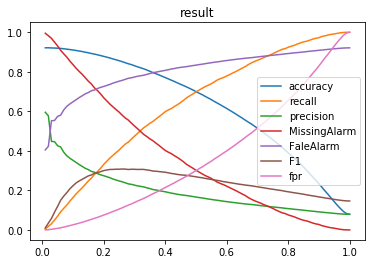

In [14]:
x_list = 1 - np.arange(0, 1, 0.01)
plt.title('result')
plt.plot(x_list, accuracy_list, label='accuracy')
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.plot(x_list, MissingAlarm_list, label='MissingAlarm')
plt.plot(x_list, FalseAlarm_list, label='FaleAlarm')
plt.plot(x_list, F1_list, label='F1')
plt.plot(x_list, fpr_list, label='fpr')
plt.legend()
plt.show()

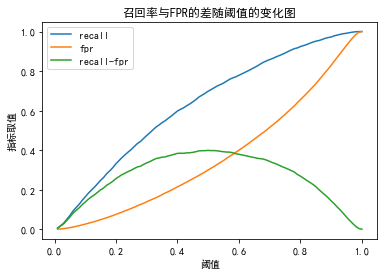

In [15]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, fpr_list, label='fpr')
plt.plot(x_list, [recall_list[i] - fpr_list[i] for i in range(len(recall_list))], label='recall-fpr')
plt.legend()
plt.xlabel('阈值')
plt.ylabel('指标取值')
plt.title('召回率与FPR的差随阈值的变化图')
plt.show()

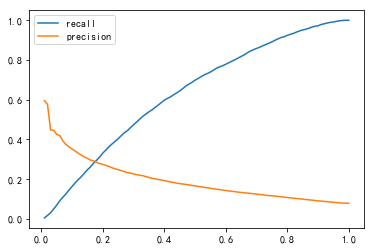

In [16]:
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.legend()
plt.show()

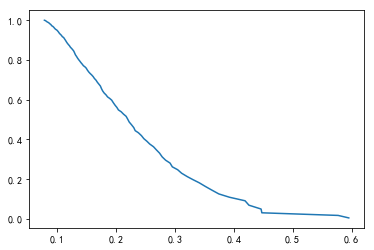

In [17]:
plt.plot(precision_list, recall_list, label='precision')
plt.show()

In [18]:
K_S = max([recall_list[i] - fpr_list[i] for i in range(len(recall_list))])
print(K_S)
np.argmax([recall_list[i] - fpr_list[i] for i in range(len(recall_list))])

0.3986387907123267


50

In [19]:
accuracy_list[50]

0.7000471521714388

In [14]:
X.columns

Index(['pre_app_merged_DAYS_LAST_DUE_mean',
       'pre_app_merged_CODE_REJECT_REASON_SCOFR',
       'pre_app_merged_DAYS_FIRST_DUE_mean',
       'bureau_merged_AMT_CREDIT_SUM_DEBT_max',
       'pre_app_merged_cash_CNT_INSTALMENT_max_max',
       'bureau_merged_DAYS_ENDDATE_FACT_mean', 'AMT_CREDIT',
       'pre_app_merged_AMT_DOWN_PAYMENT_max',
       'pre_app_merged_installments_AMT_INSTALMENT_max_min',
       'pre_app_merged_AMT_APPLICATION_max',
       ...
       'pre_app_merged_installments_count_max',
       'bureau_merged_AMT_CREDIT_SUM_max', 'REGION_RATING_CLIENT_W_CITY',
       'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE',
       'REGION_RATING_CLIENT', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
       'CODE_GENDER'],
      dtype='object', length=106)

In [15]:
X.dtypes.value_counts()

float64    98
int64       8
dtype: int64